In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("project_134.ipynb")

# Final Project 
    
## PSTAT 134 (Winter 2024) 
    
## Collaboration Policy 

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: William Markevitch

In [2]:
%xmode Verbose

Exception reporting mode: Verbose


<!-- BEGIN QUESTION -->

## Question 1: Using Linear Algebra for Optimization
In recommender system module, low-rank matrix factorization was used to execute latent factor modeling of movie ratings data.

Specifically, we calculated matrices $U$ and $V$ to solve the following optimization problem (if all ratings were given):
$$
\begin{aligned}
\min_{U,V} f(U,V) &= \min_{U,V} \|R - V U^T\|_F^2
=\min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 \right\},
\end{aligned}
$$
where
$$
\begin{aligned}
D_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

The best $U$ and $V$ were calculated iteratively by improving on current estimates:
$$
\begin{aligned}
u_i^{\text{new}} &= u_i + 2\alpha D_{mi}(r_{mi} -  v_m u_i^T)\cdot v_m\\
v_m^{\text{new}} &= v_m + 2\alpha D_{mi}(r_{mi} -  v_m u_i^T)\cdot u_i,
\end{aligned}
$$
where $\alpha$ is the step-size that is to be chosen by the user, $i = 1,2,\ldots, I$, $m = 1,\ldots,M$. (We won't discuss the role of $\alpha$ in this class, but treat it as an arbitrary, but given, parameter) 

We can make calculating the updates more efficient by calculating them with matrix operations. For example, instead of calculating each deviation $\gamma_{mi} = r_{mi} - v_m u_i^T$ separately for all $m=1,2,\dots,M$ and $i=1,2,\dots,I$, matrix $\Gamma$ of all deviations can be computed together using matrix operation _(verify for yourself)_:
$$\Gamma = R - VU^T$$

Similarly, updating $U$ and $V$ can be combined into matrix calculations which makes the optimization procedure more efficient.

First, note that updates for $u_i$, $i=1,2,\dots,I$ can be rewritten as
$$
\begin{aligned}
u_1^{\text{new}} &= u_1 + 2\alpha D_{m1}\gamma_{m1}\cdot v_m\\
u_2^{\text{new}} &= u_2 + 2\alpha D_{m2}\gamma_{m2}\cdot v_m\\
\vdots\quad &\qquad\qquad\vdots\\
u_I^{\text{new}} &= u_I + 2\alpha D_{mI}\gamma_{mI}\cdot v_m.
\end{aligned}
$$
Stacking all $I$ equations into a matrix form, 
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha (D_{m-}\circ\Gamma_{m-})^T v_m,
\end{aligned}
$$
where $I_{m-}$ and $\Gamma_{m-}$ are the $m$-th row of $\Gamma$ and $D$ (use the notation $\Gamma_{-i}$ for the $i$-th column). Hadamard product (elementwise matrix product) is denoted with $\circ$. When evaluating $U^{\text{new}}$, the latest updated values of $U$, $V$, and $\Gamma$ are used.

Note that there are $M$ such update equations (one for each $m=1,2,\dots,M$) that can also be combined into one matrix update equation involving matrices $U$, $V$, $\Gamma$ and scalars. As stated earlier, since $\alpha$ is assumed to be an arbitrary step-size parameter, we can replace $\alpha/M$ with $\alpha$.

### Question 1a: Using Linear Algebra for Optimization

Complete the following update equations:
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha[\text{some function of }\Gamma][\text{some function of }V]\\
V^{\text{new}} &= V + 2\alpha[\text{some function of }\Gamma][\text{some function of }U]
\end{aligned}
$$

$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha(\Gamma^T)V\\
V^{\text{new}} &= V + 2\alpha(\Gamma)U\\
\end{aligned}
$$

**SOLUTION**

<!-- END QUESTION -->

### Question 1b: Implementing Updates

In this problem, you will implement the updates calculated in the previous problem. Define the following three functions:

* `update_G(R, U, V)`: computes deviation $R-VU^T$
* `update_U(G, U, V, alpha=0.01)`: calculates update $U^{\text{new}}$
* `update_V(G, U, V, alpha=0.01)`: calculates update $V^{\text{new}}$

Each function should only be one line of matrix operations. Three functions is to be applied sequentially, using the most up-to-date estimates of $G$, $U$, and $V$.

Since some elements of `R` are `np.nan` for any missing ratings, `update_U` and `update_V` functions need to be adjusted by using `numpy.nan_to_num` function where appropriate. The function `numpy.nan_to_num` will let you replace `NaN` to some number, so that missing ratings do not interfere with updates.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
   
from IPython.display import display, HTML 


def update_G(R_, U_, V_):

    return (R_ - V_@U_.T)

def update_U(G_, U_, V_, alpha=0.01):
    
    return (U_ + 2*alpha* np.nan_to_num(G_.T)@ V_)

def update_V(G_, U_, V_, alpha=0.01):
    
    return (V_ + 2*alpha * np.nan_to_num(G_)@U_)

# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G(R_, U_, V_)

In [4]:
grader.check("q1b")

q1b results: All test cases passed!

### Question 1c: Construct Optimization Algorithm

Combine the above functions to implement the optimization algorithm to iteratively compute $U$ and $V$.

But, first, here are functions that will calculate RMSE and quantify the maximum update (in absolute value) made by `update_U` and `update_V` after they are called.

In [5]:
def rmse(X):
    """
    Computes root-mean-square-error, ignoring nan values
    """
    return np.sqrt(np.nanmean(X**2))

def max_update(X, Y, relative=True):
    """
    Compute elementwise maximum update
    
    parameters:
    - X, Y: numpy arrays or vectors
    - relative: [True] compute relative magnitudes
    
    returns
    - maximum difference between X and Y (relative to Y) 
    
    """
    if relative:
        updates = np.nan_to_num((X - Y)/Y)
    else:
        updates = np.nan_to_num(X - Y)
            
    return np.linalg.norm(updates.ravel(), np.inf)

A template for the optimization algorithm is given below. Fill-in the missing portions to complete the algorithm.

In [6]:
def compute_UV(Rdf, K=5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape            # number of movies and users
    U = np.random.rand(I, K)  # initialize with random numbers
    V = np.random.rand(M, K)  # initialize with random numbers
    G = update_G(R, U, V)     # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_U(G, U, V, alpha)
        Gnew = update_G(R, Unew, V)

        Vnew = update_V(Gnew, Unew, V, alpha)
        Gnew = update_G(R, Unew, Vnew)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index= Rdf.columns, columns=kindex)
    V = pd.DataFrame(V, index= Rdf.index, columns=kindex)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }
 
Rsmall = pd.read_pickle('data/ratings_stacked_small.pkl').unstack()

np.random.seed(134) # set seed for tests
output1 = compute_UV(Rsmall, K=10, alpha=0.001)

In [7]:
grader.check("q1c")

q1c results: All test cases passed!

Running the function on a different sized problem to check if `compute_UV` adapts to changing problem sizes.
There is nothing new to do here

In [8]:
# These tests should pass if `compute_UV` works properly
np.random.seed(134) # set seed for tests
output2 = compute_UV(Rsmall.iloc[:7, :5], K=8)

In [9]:
## TEST ##
output2['U'].shape

(5, 8)

In [10]:
## TEST ##
print((output2['V']@output2['U'].T).round(2))

                                   rating                        
user id                               1     85    269   271   301
movie id movie title                                             
132      Wizard of Oz, The (1939)    4.00  5.00  5.00  5.00  4.01
238      Raising Arizona (1987)      4.00  2.00  5.00  4.00  3.01
748      Saint, The (1997)           1.92  1.53  1.97  1.47  1.52
196      Dead Poets Society (1989)   5.00  4.00  1.00  4.00  4.00
197      Graduate, The (1967)        5.00  5.00  5.00  4.00  5.01
185      Psycho (1960)               4.00  3.67  5.00  3.00  3.80
194      Sting, The (1973)           4.01  4.01  5.00  5.00  3.99


In [11]:
## TEST ##
output2['V'].shape

(7, 8)

In [12]:
## TEST ##
output2['U'].index

MultiIndex([('rating',   1),
            ('rating',  85),
            ('rating', 269),
            ('rating', 271),
            ('rating', 301)],
           names=[None, 'user id'])

In [13]:
## TEST ##
output2['V'].index

MultiIndex([(132,  'Wizard of Oz, The (1939)'),
            (238,    'Raising Arizona (1987)'),
            (748,         'Saint, The (1997)'),
            (196, 'Dead Poets Society (1989)'),
            (197,      'Graduate, The (1967)'),
            (185,             'Psycho (1960)'),
            (194,         'Sting, The (1973)')],
           names=['movie id', 'movie title'])

In [14]:
## TEST ##
output2['U'].columns

RangeIndex(start=0, stop=8, step=1, name='k')

In [15]:
## TEST ##
output2['V'].columns

RangeIndex(start=0, stop=8, step=1, name='k')

<!-- BEGIN QUESTION -->

### Question 1d: Interpret Diagnostic Plots

Following figures tell us if the optimization algorithm is working properly.

In [16]:
import altair as alt
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

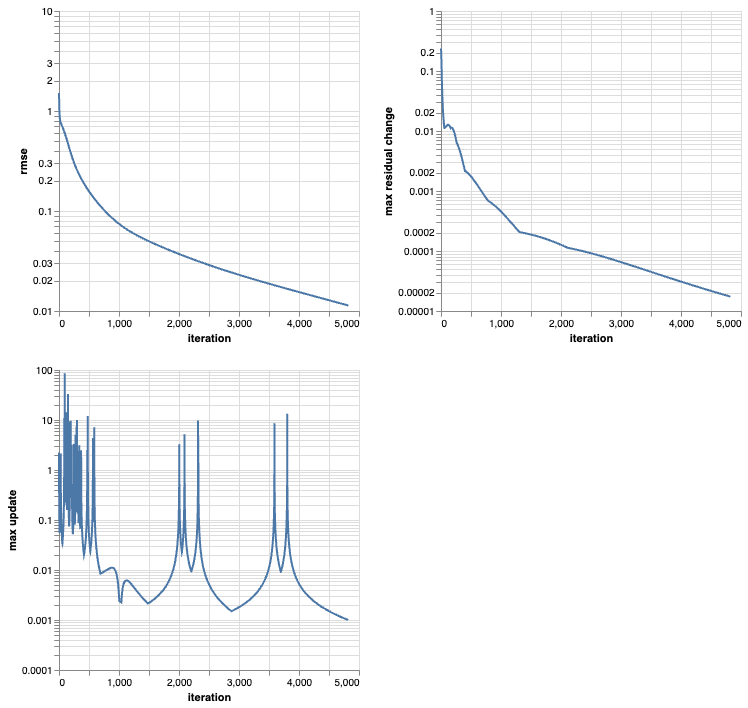

In [17]:
import altair as alt
logscale = alt.Scale(type='log', base=10)
fig_rmse = \
    alt.Chart(output1['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('rmse:Q', scale=logscale)
    )
fig_max_residual_change = \
    alt.Chart(output1['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max residual change:Q', scale=logscale)
    )
fig_updates = \
    alt.Chart(output1['update'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale=logscale)
    )
alt.vconcat(
    fig_rmse | fig_max_residual_change,
    fig_updates 
)

By referring back to the function used to calculate the quantities in each figure, describe what each figure is showing and interpret the behavior of the optimization algorithm.

**SOLUTION**

By defining the `output1` varible using the computation of $U$ and $V$ matrix, representing the matrices of users to ratings and movies to ratings, we can determine how quickly the algorithm reaches optimization. Firstly, we determine the RMSE from the residual matrix $G$ obtained after each iteration, and as the iterations progress, we should observe the RMSE decrease, indicating that the reconstructed matrix obtained from $U \times V^T$ better approximates the original ratings from the matrix $R$. The first plotted figure represents the RMSE vs Iterations, which we explained is the difference from actuals and predicted data. In order for the RMSE to become minimized, the algorithm requires over 4,500 iterations, implying that this is not very effective model, will require a lot computations, thus making it relativelyl computationally expensive.

Next, we observe the rate of change of the maximum residual change. From our `compute_UV` function, the residual matrix $G$ is updated after each iteration of the optimization process, and then maximum residual change represents the maximum absolute difference between corresponding elements of $G$ in the back-to-back iterations for each iteration, where the maximum is updated during each iteration. Ideally, we expect a decreasing trend in maximum residual change that points to the algorithm converging towards a solution, as the changes in residual values between iterations become arbitrarly small. In the second plot, we see the Max Residual Change vs Iterations, and observe a similar trend to the RMSE plot that involves a progressive decrease in the maximum residual change, still requiring at least 5,000 iterations to reach a small value, inducing the same concerns computationally as the RMSE. 

Lastly, we evalute the maximum update values against the iteration. We calculate the maximum update in the $U$ and $V$ matrices between consecutive iterations with the `max_update` portion of the `compute_UV` function, by comparing the updated matrices $U$ and $V$ with their previous values. In the plot we see an odd pattern of rising and decreasing maximum update values at each iteration, indicating that the update between iterations is not consistent and tends to oscillate between a larger and smaller difference. It could due to the algorithm overshooting around the optimal solution rather than converging steadily towards it in rapid succession. We want to analyze the rate of decrease in max update to show how quickly the algorithm is stabilizing the latent factors, and by doing so we see a slow convergence rate to a minimal maximum update value, where even past the 5,000 iterations tick, we still do not see an infinitely small change. This implies that there is room for improvement in the model. 

.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1e: Analyze Large Dataset

Following code will analyze a larger dataset:

In [18]:
# run on larger dataset
Rbig = pd.read_pickle('data/ratings_stacked.pkl').unstack()[100:]

np.random.seed(134) # set seed for tests
output3 = compute_UV(Rbig, K=5, alpha=0.001, max_iteration=500)

Rhatbig = output3['V']@output3['U'].T

/tmp/ipykernel_3221/1847306426.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ], axis=1).stack().dropna().reset_index()[['fit','observed']]


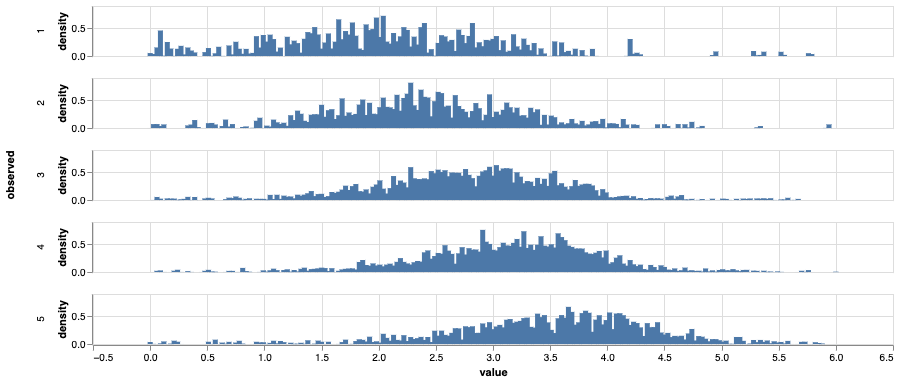

In [19]:
fit_vs_obs = pd.concat([
    Rhatbig.rename(columns={'rating':'fit'}),
    Rbig.rename(columns={'rating':'observed'}),
], axis=1).stack().dropna().reset_index()[['fit','observed']]

fit_vs_obs = fit_vs_obs.iloc[np.random.choice(len(fit_vs_obs), 5000)]

alt.Chart(fit_vs_obs).transform_density(
    density='fit',
    bandwidth=0.01,
    groupby=['observed'],
    extent= [0, 6]
).mark_bar().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('observed:N')
).properties(width=800, height=50)

**Question**: Consider the above plot.
- By reading the code, comment on what the plot is illustrating. 
- What happens when you add `counts=True` to `transform_density`? What can you conclude?

**SOLUTION**

The plot generated by the code illustrates the density distribution of the fitted/predicted ratings vs. the observed ratings (fit vs. observed), where the x-axis is the predicted ratings and the y-axis is the probability density, and each row represents an observed rating from 1-5. The bars represent the density of fitted ratings for each observed rating, and the higher bars indicate regions where the fitted ratings are more concentrated. The plot helps visualize how well the fitted ratings match the observed ratings across different levels.

By adding `counts=True` to `transform_density`, the plot will show the count of data points in each bin and not the density. We can compared the plots when the count parameter is True and False, and conclude that if the density plot closely matches the count plot, then the model's predicted ratings are aligned with the observed ratings. So, from the plots, we can see that for observed rating level 5, the density and count plots match quite well. We see a similar phenomenon with observed rating level 4, and less and less identical for observed level 3,2, and 1. In conclusion, the model predicts the densities the observed ratings 4 and 5 quite well, meanwhile it produces a less acurate prediction for levels 3,2, and 1.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1f: Make Recommendation

What movies would you recommend to `user id` 601? Do you see any similarities to movies the user rated high?

**SOLUTION**

In [20]:
Rbig['rating', 601].sort_values(ascending=False).head(15)

movie id  movie title                                             
168       Monty Python and the Holy Grail (1974)                      5.0
132       Wizard of Oz, The (1939)                                    5.0
173       Princess Bride, The (1987)                                  5.0
228       Star Trek: The Wrath of Khan (1982)                         5.0
179       Clockwork Orange, A (1971)                                  5.0
181       Return of the Jedi (1983)                                   5.0
154       Monty Python's Life of Brian (1979)                         5.0
201       Evil Dead II (1987)                                         5.0
429       Day the Earth Stood Still, The (1951)                       5.0
763       Happy Gilmore (1996)                                        5.0
1084      Anne Frank Remembered (1995)                                5.0
921       Farewell My Concubine (1993)                                5.0
258       Contact (1997)                     

In [21]:
Rhatbig['rating', 601].sort_values(ascending=False).head(15)

movie id  movie title                           
172       Empire Strikes Back, The (1980)           9.961383
204       Back to the Future (1985)                 7.905657
1500      Santa with Muscles (1996)                 4.932997
168       Monty Python and the Holy Grail (1974)    4.223360
1467      Saint of Fort Washington, The (1993)      4.016834
408       Close Shave, A (1995)                     3.973421
216       When Harry Met Sally... (1989)            3.822423
483       Casablanca (1942)                         3.599893
183       Alien (1979)                              3.594180
194       Sting, The (1973)                         3.494979
191       Amadeus (1984)                            3.487597
169       Wrong Trousers, The (1993)                3.476869
1656      Little City (1998)                        3.476402
1138      Best Men (1997)                           3.407717
180       Apocalypse Now (1979)                     3.395319
Name: (rating, 601), dtype: float64

In [22]:
filtered_Rhatbig_601 = Rhatbig['rating', 601][Rhatbig['rating', 601].values <= 5]
filtered_Rhatbig_601.sort_values(ascending=False).head(15)

movie id  movie title                           
1500      Santa with Muscles (1996)                 4.932997
168       Monty Python and the Holy Grail (1974)    4.223360
1467      Saint of Fort Washington, The (1993)      4.016834
408       Close Shave, A (1995)                     3.973421
216       When Harry Met Sally... (1989)            3.822423
483       Casablanca (1942)                         3.599893
183       Alien (1979)                              3.594180
194       Sting, The (1973)                         3.494979
191       Amadeus (1984)                            3.487597
169       Wrong Trousers, The (1993)                3.476869
1656      Little City (1998)                        3.476402
1138      Best Men (1997)                           3.407717
180       Apocalypse Now (1979)                     3.395319
1616      Desert Winds (1995)                       3.387911
1130      Jupiter's Wife (1994)                     3.362945
Name: (rating, 601), dtype: float64

Based on our predictive model, we would recommened this user with The Empire Strikes Back, Back to the Future, and Santa with Muscles. These movies are all considered science fiction, or otherwise outside of true reality, which line up similarly to the ones this user rated highly, such as Star Trek: The Wrath of Khan, Return of the Jedi, A Clockwork Orange, as well as Happy Gilmore and Monty Python and the Holy Grail, which have a similar theme to Santa with Muscles. 

However, we see that the top 2 highly predicted movies The Empire Strikes Back and Back to the Future, already have ratings, and thus we cannot recommend these movies to a use that has already been seen, so we recommend Santa with Muscles and Monty Python and the Holy Grail.

<!-- END QUESTION -->

## Question 2: Regularization

One of the common problems in machine learning is overfitting, and a common method that remedies overfitting is regularization.

Recall that we solved the following optimization problem
$$
\begin{aligned}
\min_{U,V} f(U,V) &= \min_{U,V} \|R - V U^T\|_F^2
=\min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 \right\},
\end{aligned}
$$
where
$$
\begin{aligned}
D_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

To prevent overfitting, we can introduce $L_2$ regularization on both the user matrix and the movie matrix. Then the new optimization problem is

$$
\begin{aligned}
\min_{U,V} g(U,V) &=\min_{U,V} \|R - V U^T \|_F^2 + \lambda(\|U\|_F^2 + \|V\|_F^2)\\
&= \min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 + \lambda (\sum_{i=1}^{I}\|u_i\|_2^2 + \sum_{m=1}^{M}\|v_m\|_2^2) \right\}\\
\end{aligned}
$$
where $\lambda$ is a tuning parameter that determines the strength of regularization.

<!-- BEGIN QUESTION -->

### Question 2a: Derive New Gradients and Update Rules

Based on the new objective function $g(U,V)$, derive its gradients and update rules for $U^{\text{new}}$ and $V^{\text{new}}$.

$$\frac{\partial g}{\partial U} = 2 \lambda U$$
$$\frac{\partial g}{\partial V} = 2\lambda V$$

$$U^{\text{new}} = U + \alpha( 2\Gamma^T V - \frac{\partial g}{\partial U}) = U + 2\alpha(\Gamma^T V - \lambda U)$$
$$V^{\text{new}} = V + \alpha(2\Gamma U - \frac{\partial g}{\partial V}) = U + 2\alpha(\Gamma U - \lambda V)$$



<!-- END QUESTION -->

### Question 2b: Implementing Updates

Implement new update functions similarly as in q1b.

In [23]:
import numpy as np
import pandas as pd

def update_G_reg(R_, U_, V_):
    
    return R_ - V_@U_.T

def update_U_reg(G_, U_, V_, lam, alpha=0.01):
    
    return U_ + 2*alpha*(np.nan_to_num(G_.T)@V_ - lam*U_)

def update_V_reg(G_, U_, V_, lam, alpha=0.01):
    
    return V_ + 2*alpha*(np.nan_to_num(G_)@U_ - lam*V_)

# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2
lam = 5.0

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G_reg(R_, U_, V_)


In [24]:
update_V_reg(G_, U_, V_, lam).round(3)

array([[0.899, 0.263],
       [0.614, 0.793],
       [0.801, 0.088],
       [0.01 , 0.184],
       [0.807, 0.083]])

In [25]:
import numpy as np
import pandas as pd

def update_G_reg(R_, U_, V_):
    
    return R_ - V_@U_.T

def update_U_reg(G_, U_, V_, lam, alpha=0.01):
    
    return U_ + 2*alpha*(np.nan_to_num(G_.T)@V_ - lam*U_)

def update_V_reg(G_, U_, V_, lam, alpha=0.01):
    
    return V_ + 2*alpha*(np.nan_to_num(G_)@U_ - lam*V_)

# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2
lam = 5.0

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G_reg(R_, U_, V_)


In [26]:
update_V_reg(G_, U_, V_, lam).round(3)

array([[0.899, 0.263],
       [0.614, 0.793],
       [0.801, 0.088],
       [0.01 , 0.184],
       [0.807, 0.083]])

In [27]:
grader.check("q2b")

q2b results: All test cases passed!

### Question 2c: Construct Optimization Algorithm

Combine the above functions to implement the optimization algorithm to iteratively compute $U$ and $V$.

In [28]:
def compute_UV_reg(Rdf, K=5, lam=0.5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape            # number of movies and users
    U = np.random.rand(I, K)  # initialize with random numbers
    V = np.random.rand(M, K)  # initialize with random numbers
    G = update_G(R, U, V)     # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_U_reg(G, U, V, lam, alpha)
        Gnew = update_G_reg(R, Unew, V)

        Vnew = update_V_reg(Gnew, Unew, V, lam, alpha)
        Gnew = update_G_reg(R, Unew, Vnew)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index=Rdf.columns, columns=kindex)
    V = pd.DataFrame(V, index=Rdf.index, columns=kindex)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }
 
Rsmall = pd.read_pickle('data/ratings_stacked_small.pkl').unstack()

np.random.seed(134) # set seed for tests
output4 = compute_UV_reg(Rsmall, K=10, lam=0.5, alpha=0.001)

In [29]:
grader.check("q2c")

q2c results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 2d: Investigating the Effects of Regularization

Adding the regularization terms to the objective function will affect the estimates of $U$ and $V$. Here, we consider comparing the user matrix $U$.

Using the dataset *Rsmall*, obtain two estimated user matrices, say $\hat{U}$ for a non-regularized model and $\hat{U}_{\text{reg}}$ for a regularized model. Select $K = 20$ and $\lambda = 5$. Come up with an effective visualization for comparing $\hat{U}$ and $\hat{U}_{\text{reg}}$, and describe any differences you notice. Additionally, analyze whether the observed differences in patterns align with the concept of regularization.

Provide reasoning supported by evidence, such as code implementation and results.

**SOLUTION**

To provide an effective way to visualize the differences between the regularized matrix $U$ and a non regularized matrix, both representing the matrices of users to ratings combination, I decided to go with heatmaps to identify their differences. They are able to display the user rating with the user id in regards to what the algorithm predicts their ratings are going to be. The heatmap for the non-regularized $U$ matrix is showing a wider range of values, varying from $-0.5$ to $1.25$. This is due to the idea that a non-regularized model can adjust the values in the $U$ matrix to minimize the objective function, which could potentially leading to overfitting. So, to accomodate this overfitting, we apply the regularized model and introduce $\lambda$ to the function. Then, the heatmap for the regularized $U$ matrix displays more concentrated values around zero. This is because the regularization term (lam * U_) in the update_U_reg function penalizes large values in the U matrix, effectively shrinking the values towards zero, ranging only from $-0.1$ to $0.7$. By adding the regularization term to the algorithm, the model is less likely to overfit the data and from using complex patterns that may not generalize well to new data. In this example, the use of $\lambda = 5$ is relatively strong in terms of regularizing the range of values the ratings can take in. 

In the heatmap comparisons, we see that the non-regularized map has distinct colors compared to the squares and values next to them, which explains the wider range of values those square can correspond to a color. The more possible values the larger the color range for the map, so we see a wider range of colors and more scattered ratings across the non-regularized heatmap. As opposed to this, the regularized heatmap contains a smaller range of colors, correlating with the idea that the range of values the ratings could hold are much smaller and less dispersed amongst each other. This lessering is caused by the regularization term, which leads to a narrower range of values in the regularized $U$ matrix compared to the non-regularized $U$ matrix. Consequently, the regularized heatmap displays a smaller range of colors, as the values in the matrix are concentrated around zero and have a smaller spre

In [30]:
np.random.seed(134) # set seed for tests
output_noreg = compute_UV(Rsmall, K=20, alpha=0.001)
output_reg = compute_UV_reg(Rsmall, K=20, lam=5.0, alpha=0.001)

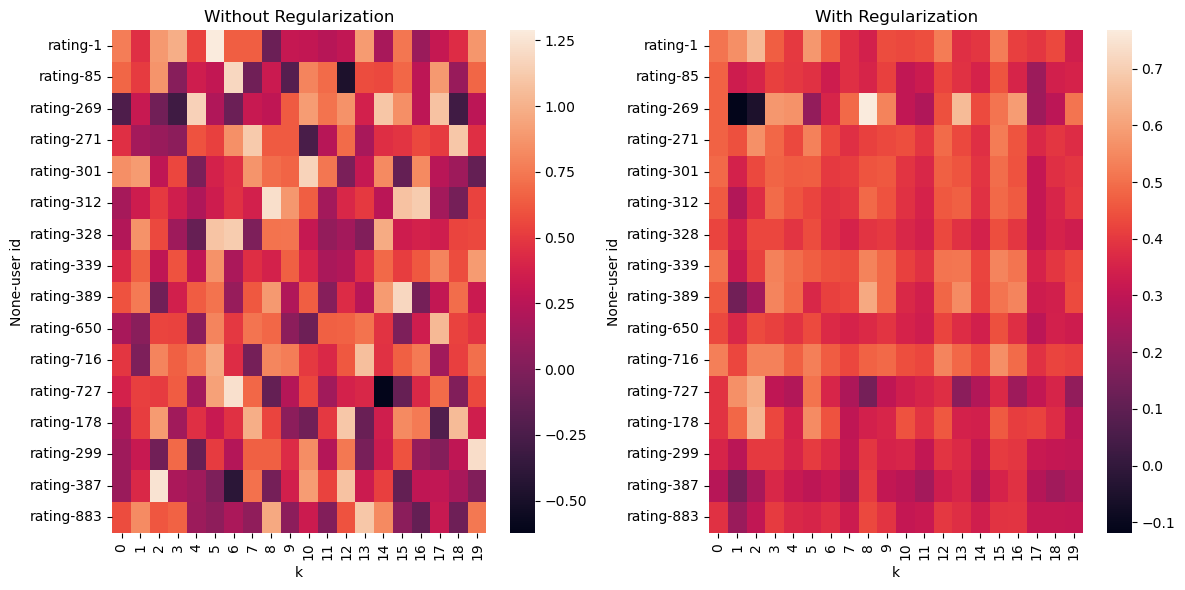

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6)) 

sns.heatmap(output_noreg['U'], ax=axs[0])
axs[0].set_title('Without Regularization')

sns.heatmap(output_reg['U'], ax=axs[1])
axs[1].set_title('With Regularization')

plt.tight_layout() 
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2e: Practical Aspects

In the previous question, a specific values for $K$ and $\lambda$ were provided. Now, try applying various $K$'s and $\lambda$'s. Specifically, try the following:

 - While keeping $K$ constant, experiment with different values of $\lambda$. What do you notice? Why do you think this happens?
 - While keeping $\lambda$ constant, experiment with different values of $K$. What do you notice? Why do you think this happens?

If your optimization algorithm is correctly implemented, you will notice that the choice of $K$ and $\lambda$ has a significant impact on the final estimates. Hence, selecting appropriate values for $K$ and $\lambda$ is crucial when applying the recommendation algorithm in practice. As a practitioner, how would you approach choosing $K$ and $\lambda$?

Provide reasoning supported **by evidence**, such as code implementation and results.

**SOLUTION**

To understand what happens to our estimations in respect to $K$ and $\lambda$, we chose a range of corresponding values that would give us a picture of the effects of those respective parameters. We first keep $K$ constant and experiment with different $\lambda$ values. In the first part of the code below, we fix $K=65$ and try various values of lambda ranging from 0.001 to 10, and then plot each of the produced RMSE curves for each lambda value on the same plot. Our observations tells us that a higher lambda value, indicating a stronger regularization term, tend to have higher RMSE values, especially throughout the earlier iterations. Meanwhile the lower lambda values, indicating a weaker regularization term, tend to have lower RMSE values in the early iterations. From my understanding, the regularization parameter $\lambda$ effects the strength of the regularization term in the algorithm. Higher lambda values impose a stronger restraint on the size of the U and V matrices, effectively preventing overfitting. Whereas lower lambda values allow the functions to fit the given data better, leading to lower RMSE. Additonally, we see that for $\lambda = 0.001$, the RMSE curve ends before the last iterations, unlike the other RMSE curves, such as $\lambda = 0.01$, thus convincing us that $\lambda = 0.01$ is the more optimal regularization term.

In the next code cell, we fix $\lambda=0.01$ as  and tried various values of $K$ ranging from 1 to 65, and again plotting the RMSE curves for each $K$ value. From the plot, we observed that the lower $K$ values tend to have higher RMSE, which indicates an underfitting problem, and the higher K values have lower RMSE. Theoretically, beyond a certain point, the RMSE starts to increase with larger $K$ values, potentially indicating overfitting, but this was not captured in our plot. I understand that the parameter $K$ represents the number of latent factors used to approximate the user to rating matrix $U$. Then, a higher K value should allow the model to capture more complex patterns and relationships in the data, potentially leading to better approximations and lower RMSE on the training data. However, if $K$ is too high, the model may become overly complex and start overfitting to the given data, which would then perform poorly when attempting to generalize new data. This can result in an increase in RMSE on a new set of data. Conversely, if $K$ is too low, the model may not be complex enough to capture the patterns in the data, resulting in an underfitting problem and higher RMSE on both the seen and unseen data. 

Effectively, we are able to determine that the optimal values our plot tells us to consider our best model is $K=65$ and $\lambda = 0.01$. To visualize this, we can use the same strategy of comparing the RMSE, Maximum Residual Change, and Maximum Update plots as we did earlier above. The RMSE plot shows residual matrix G at each iteration of the optimization process, and provides insights into the rapid convergence behavior of the algorithm and the final approximation error achieved, which is visibly steeper than the RMSE plot of the non-regularized algorithm we analyzed prior. Similarly, then Maximum Residual Change plot also achieves convergence at a much quicker pace than the non-regularized algoithm, and finally the Maximum Update plot, althought may be tricky to judge based on its oscillating values, carries an underlying converting pattern towards 0, also at a much quicker than the non-regularized algorithm.

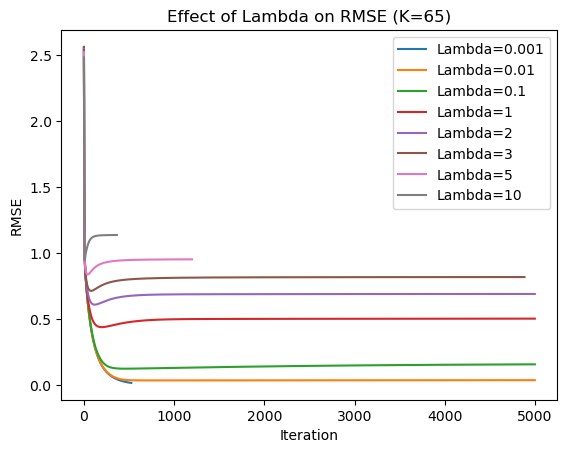

In [32]:
lambda_values = [0.001, 0.01,0.1, 1, 2,3, 5,10]
results_lambda = {}

for lam in lambda_values:
    np.random.seed(134)
    output_lambda = compute_UV_reg(Rsmall, K=65, lam=lam, alpha=0.001)
    results_lambda[lam] = output_lambda['rmse']

#Visualize RMSE for different lambda values
for lam, rmse_data in results_lambda.items():
    plt.plot(rmse_data['iteration'], np.sqrt(rmse_data['rmse']), label=f'Lambda={lam}')

plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Effect of Lambda on RMSE (K=65)')
plt.legend()
plt.show()

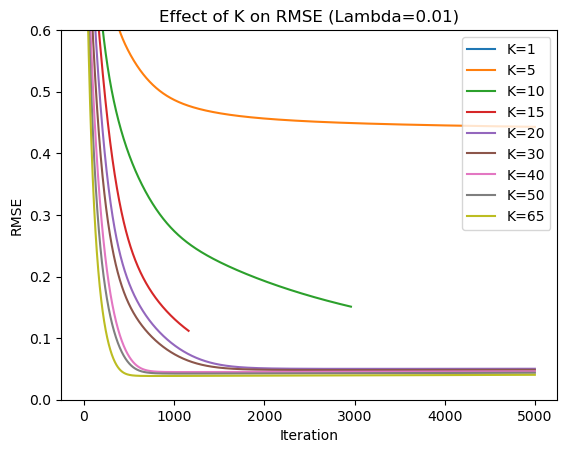

In [33]:
K_values = [1,5,10,15,20,30,40,50, 65]

results_K = {}

for k in K_values:
    np.random.seed(134)
    output_K = compute_UV_reg(Rsmall, K=k, lam=0.01, alpha=0.001)
    results_K[k] = output_K['rmse']

#Visualize RMSE for different K values
for k, rmse_data in results_K.items():
    plt.plot(rmse_data['iteration'], np.sqrt(rmse_data['rmse']), label=f'K={k}')

plt.ylim(0, .6)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Effect of K on RMSE (Lambda=0.01)')
plt.legend()
plt.show()

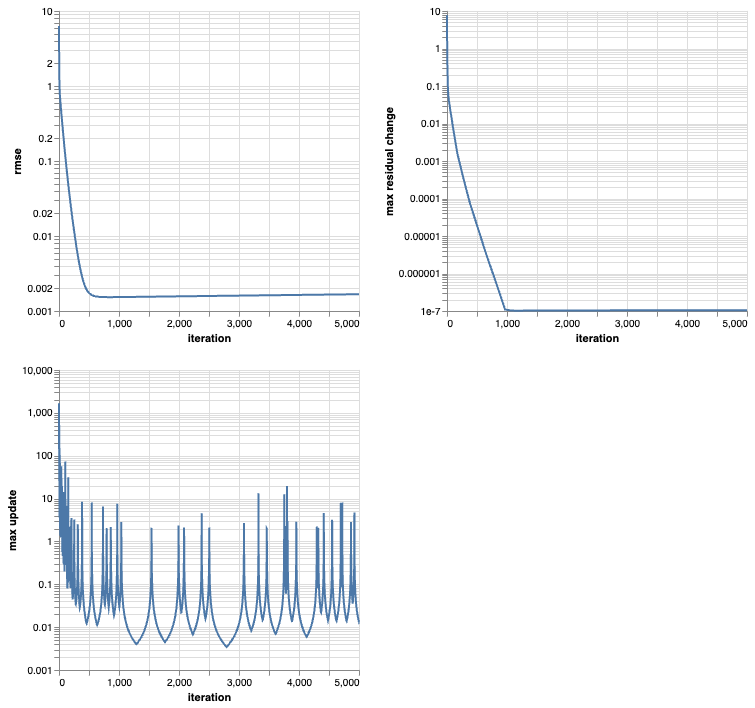

In [34]:
import altair as alt

#OPTIMAL MODEL

best_model = compute_UV_reg(Rsmall, K=65, lam=0.01, alpha=0.001)

logscale = alt.Scale(type='log', base=10)
fig_rmse = \
    alt.Chart(best_model['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('rmse:Q', scale=logscale)
    )
fig_max_residual_change = \
    alt.Chart(best_model['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max residual change:Q', scale=logscale)
    )
fig_updates = \
    alt.Chart(best_model['update'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale=logscale)
    )
alt.vconcat(
    fig_rmse | fig_max_residual_change,
    fig_updates 
)

<!-- END QUESTION -->

## Question 3: Segmentation in Latent Factor Space

Now that we have user matrix $U$ and movie matrix $V$, suppose we want to use the newly learned representation for an advertising campaign. 

Suppose you are leading the planning of an online advertising campaign and you have a fixed budget. With the budget, you can create 5 variations of an ad, and you want to create the variations based on a representative movie each group likes.

The advertisements will entice the viewer to sign up for a mailing list by offering a free poster. The goal of the advertising campaign is two fold: 

1. Get potential customers to sign up using their email address by offering a free poster among the 5 "representative" movies
2. Learn their user segment placement preference to use for the starting point for movie recommendations once they sign up

In order to achieve this goal, we want to 
1. Produce clusterings of users
2. Balance performance metric of clustering results and practical considerations to choose one of the clustering results.

We will tackle this step by step.

<!-- BEGIN QUESTION -->

### Question 3a: Concatenate matrix factors and cluster

Entries in either matrix factors are just points in $k$-dimensional latent variable space. We will use both $U$ and $V$ for segmentation by combining them into one large clustering problem.

Once clusters are identified, you will qualitatively inspect the users and movies in the cluster and decide on a "representative" movie from each cluster.

Consider concatenating $U$ and $V$ into one large matrix. Since these matrices have arbitrary scaling, it would be a good idea to standardize the columns before concatenating them. Standardize $U$ and $V$ separately, then concatenate with numpy's `concatenate` method. Call this concatenated matrix, `UVstd`.

Apply hierarchical and K-means clustering methods on `UVstd`.  For each clustering method, identify 5 clusters. Compare the clustering results by applying three different [cluster validation metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) to evaluate the clustering performance. 

Which cluster performance metrics can you use? Do we have true labels? Does one performance metric seem to clearly be better than another? Why would you choose one metric over another? What interpretation, if any, does each metric have in the context of our problem? Explain.

Note: In this part, 
- Creating a new data `Rmedium` by `ratings_stacked.pkl` and `Rsmall`,
    1. Loading `rantings_stacked.pkl` and adding the `user id` having less than 134 NA's in it to `user id` in `Rsmall`,
    2. Adding movies with `movie id` $134-234$ to `movie id` in `Rsmall`,
    3. Name the new dataset as `Rmedium` and use `Rmedium` to do clustering.
- Using the 'best' model you select in Question 2e to compute `UVstd`.

**SOLUTION**

In order to determine the clusters and go on with , we frist have create a dataframe able to be worked with. This means creating an index mask of all rows of `user id` having less than 134 NA's in it to `user id` in `Rsmall`, adding movies with `movie id` $134-234$ to `movie id` in `Rsmall`, and finally concatenating both `Rsmall` and our out dataframe of indexed rows, naming it `Rmedium` for recreational use. Using our best found parameters above for our regularized optimzation algorithm, we are able to create our best model using $K=65$ and $\lambda = 0.01$, and using this for our clustering. By standardizing matrices $U$ and $V$ of our chosen model, we can then concatenate them, calling the concatenated matrix, `UVstd`.In this scenario, we do not have true labels for the data points, or  the rows of UVstd. So we will rely on  cluster validation metrics to evaluate the quality of the clustering results. For this analysis, we have chose the following metrics: the Silhouette Score, the Davies-Bouldin Score, and the Calinski-Harabasz Index. 

Firstly, the Silhouette Score is a measure of how similar a data point is to its assigned cluster compared to other clusters. It ranges from -1 to 1, where higher values indicate better clustering. A Silhouette Score close to 1 suggests that the data point is well-matched to its own cluster and poorly matched to neighboring clusters. In our case, a higher Silhouette Score would indicate that the users and movies within each cluster are closely related, while being well-separated from other clusters. With a Hierarchical clustering of $0.030$ and K-means clustering of $0.034$, we see that both scores are relatively low and close to zero, but K-means clustering has a slightly higher Silhouette Score compared to hierarchical clustering, indicating that the clusters formed by K-means are slightly more compact and well-separated.

Then, the Davies-Bouldin Score provides us with a ratio of the sum of within-cluster scatter to between-cluster separation, where lower values indicate better clustering, as it means that the clusters are compact and well-separated. For our algorithm, a lower Davies-Bouldin Score would suggest that the users and movies within each cluster are similar to each other, while being distinct from other clusters. Our code reveals a
Hierarchical clustering value of  $5.230$ and K-means clustering value of $4.833$. We understand that smaller values are better for the Davies-Bouldin Score, and since the K-means clustering has a lower score compared to hierarchical clustering, this suggests that the clusters formed by K-means have a better ratio of within-cluster scatter to between-cluster separation.

Lastly, the Calinski-Harabasz Index is also a ratio that measures the between-cluster dispersion and the within-cluster dispersion, but unlike the Davies-Bouldin Score, higher values indicate better clustering. A higher Calinski-Harabasz Index would imply that the users and movies within each cluster are closely related , while the clusters themselves are well-separated. Our code tells us that our has a Hierarchical clustering value of  $59.915$ and a K-means clustering value of $65.317$. For our scenario, higher values indicate better clustering for the Calinski-Harabasz Index, so the K-means clustering achieves a higher score than hierarchical clustering, implying that the clusters formed by K-means have a better balance between within-cluster dispersion and between-cluster dispersion.

Based on the output from your code, the Silhouette Score and Calinski-Harabasz Index suggest that K-means clustering performs better than hierarchical clustering, as it achieves higher values for these metrics. However, the Davies-Bouldin Score favors hierarchical clustering due to its lower value. In our case, where we aim to segment users and movies into distinct groups for qualitative inspection and representative movie selection, the Silhouette Score and Calinski-Harabasz Index may be more relevant. These metrics emphasize the compactness of clusters and the separation between clusters, which aligns with our goal of identifying well-defined segments. Once clusters are identified, we also qualitatively inspected the users and movies in the cluster and decided on a "representative" movie from each cluster. For the cluster 0 we picked the movie Dances with Wolves (1990), for cluster 1 we picked Jurassic Park (1993), for cluster 2 we picked The	Lawnmower Man (1992), for cluster 3 it was 20,000 Leagues Under the Sea (1954), and for cluster 4 we chose The Truth About Cats & Dogs (1996).




In [35]:
ratings_stacked = pd.read_pickle('data/ratings_stacked.pkl')

In [36]:
np.random.seed(134)

users_with_less_na = ratings_stacked.isna().sum(axis=1) < 134
filtered_ratings = ratings_stacked[users_with_less_na]

filtered_ratings.reset_index(inplace =True)

filtered_ratings_134_234 = filtered_ratings[(filtered_ratings['movie id'] >= 134) &  (filtered_ratings['movie id'] <= 234)]
pivot_filtered_ratings_134_234 = filtered_ratings_134_234.pivot(index=['movie id', 'movie title'], columns = 'user id')

Rmedium = pd.concat([Rsmall, pivot_filtered_ratings_134_234])

In [37]:
output_best = compute_UV_reg(Rmedium, K=65, lam=0.01, alpha=0.001)  # Using parameters from the 'best' model

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score

U= output_best['U']
V = output_best['V']

scaler_U = StandardScaler()
U_std = scaler_U.fit_transform(U)

scaler_V = StandardScaler()
V_std = scaler_V.fit_transform(V)

UVstd = np.concatenate([U_std, V_std], axis=0)

In [39]:
# Apply hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=5)
hierarchical_labels = hierarchical.fit_predict(UVstd)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=134)
kmeans_labels = kmeans.fit_predict(UVstd)

# Evaluate clustering performance without true labels

# Silhouette Score
silhouette_hierarchical = silhouette_score(UVstd, hierarchical_labels)
silhouette_kmeans = silhouette_score(UVstd, kmeans_labels)

# Davies-Bouldin Score
davies_bouldin_hierarchical = davies_bouldin_score(UVstd, hierarchical_labels)
davies_bouldin_kmeans = davies_bouldin_score(UVstd, kmeans_labels)

# Calinski-Harabasz Index
calinski_harabasz_hierarchical = calinski_harabasz_score(UVstd, hierarchical_labels)
calinski_harabasz_kmeans = calinski_harabasz_score(UVstd, kmeans_labels)


# Display the scores for comparison
print("Silhouette Score - Hierarchical:", silhouette_hierarchical, "| K-means:", silhouette_kmeans)
print("Davies-Bouldin Score - Hierarchical:", davies_bouldin_hierarchical, "| K-means:", davies_bouldin_kmeans)
print("Calinski-Harabasz Index - Hierarchical:", calinski_harabasz_hierarchical, "| K-means:", calinski_harabasz_kmeans)

Silhouette Score - Hierarchical: 0.03040510918712939 | K-means: 0.03437086928705028
Davies-Bouldin Score - Hierarchical: 5.230316627661305 | K-means: 4.8334559911201636
Calinski-Harabasz Index - Hierarchical: 59.91484609488468 | K-means: 65.31703520003762


In [40]:
# Assuming we have the labels from K-means clustering as it generally performed better in our metrics
cluster_labels = kmeans_labels

# Split the concatenated UVstd back into U and V for interpretability
num_U, num_V = U_std.shape[0], V_std.shape[0]
U_labels, V_labels = cluster_labels[:num_U], cluster_labels[num_U:]

# For simplicity, let's focus on movie clusters (V)
# Create a DataFrame for movies with their cluster labels
movies_clustered = pd.DataFrame({'movie_id': range(U_labels.shape[0]), 'cluster': U_labels})

x0 = movies_clustered[movies_clustered['cluster'] == 0]['movie_id'].unique()
x1 = movies_clustered[movies_clustered['cluster'] == 1]['movie_id'].unique()
x2 = movies_clustered[movies_clustered['cluster'] == 2]['movie_id'].unique()
x3 = movies_clustered[movies_clustered['cluster'] == 3]['movie_id'].unique()
x4 = movies_clustered[movies_clustered['cluster'] == 4]['movie_id'].unique()

z = Rmedium.reset_index()['movie id'].unique()


In [41]:
def arrayIntersection(X,Y,m,n):
    intersection = []
    for i in range(m):
        for j in range(n):
            if X[i] == Y[j]:
                intersection.append(X[i])
                break
    return intersection


In [42]:
i0 = arrayIntersection(x0, z, len(x0), len(z))[0]

r_reset = Rmedium.reset_index()
r_reset[r_reset['movie id'] == i0]

movie id                movie title rating                          \
user id                                          1   85 269  271  301  312   
9             97  Dances with Wolves (1990)    3.0  2.0 NaN  5.0  4.0  5.0   

                   ...                                          
user id  328  339  ... 934 935 936 937 938 939 940 941 942 943  
9        3.0  4.0  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[1 rows x 788 columns]

In [43]:
i1 = arrayIntersection(x1, z, len(x1), len(z))[0]

r_reset[r_reset['movie id'] == i1]

movie id           movie title rating                              \
user id                                     1   85  269 271  301 312  328   
8             82  Jurassic Park (1993)    5.0  3.0  2.0 NaN  5.0 NaN  4.0   

              ...                                          
user id  339  ... 934 935 936 937 938 939 940 941 942 943  
8        4.0  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[1 rows x 788 columns]

In [44]:
i2 = arrayIntersection(x2, z, len(x2), len(z))[0]

r_reset[r_reset['movie id'] == i2]

movie id                movie title rating                           \
user id                                          1  85 269 271  301 312 328   
26           145  Lawnmower Man, The (1992)    2.0 NaN NaN NaN  3.0 NaN NaN   

              ...                                           
user id  339  ...  934 935 936 937 938 939 940 941 942 943  
26       3.0  ...  3.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[1 rows x 788 columns]

In [45]:
i3 = arrayIntersection(x3, z, len(x3), len(z))[0]

r_reset[r_reset['movie id'] == i3]

movie id                          movie title rating                \
user id                                                    1   85 269  271   
22           141  20,000 Leagues Under the Sea (1954)    3.0  3.0 NaN  4.0   

                         ...                                          
user id 301 312 328 339  ... 934 935 936 937 938 939 940 941 942 943  
22      NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[1 rows x 788 columns]

In [46]:
i4 = arrayIntersection(x4, z, len(x4), len(z))[0]

r_reset[r_reset['movie id'] == i4]

movie id                          movie title rating                \
user id                                                    1  85  269  271   
14           111  Truth About Cats & Dogs, The (1996)    5.0 NaN  1.0  4.0   

                          ...                                          
user id  301 312 328 339  ... 934 935 936 937 938 939 940 941 942 943  
14       1.0 NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[1 rows x 788 columns]

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3b: Visualizing Clusters in Latent Space

Select the clustering method based on the evaluation results in q3a and visualize the clusters using [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html). Are the clusters and UMAP projection consistent?

**SOLUTION**

Based on the evaluation results from the previous question, K-means clustering appears to perform better than hierarchical clustering for this dataset and the chosen number of clusters. Both the Silhouette Score and Calinski-Harabasz Index favor K-means clustering, while the Davies-Bouldin Score also slightly favors K-means over hierarchical clustering. Since K-means clustering seems to be the more suitable method according to the evaluation metrics, we'll visualize the clusters obtained from K-means using UMAP. The provided code first installs the umap-learn library, then allowing us to create a UMAP reducer object with a fixed random state for reproducibility. The `fit_transform` method is applied to the UVstd data, which computes the UMAP embedding, a lower-dimensional representation of the data that preserves the structure of the set.
Next, the code creates a scatter plot of the UMAP embedding, where the $x$ and $y$ coordinates correspond to the first two dimensions of the embedding. The `kmeans_labels` are used to color the data points based on their assigned cluster. The `set_aspect` function ensures that the aspect ratio of the plot is equal, preserving the distances in the UMAP space.

The resulting plot will show the UMAP projection of the UVstd data, with each point colored according to its cluster assignment from K-means clustering. By visually inspecting the UMAP plot, we can assess whether the clusters formed by K-means are consistent with the UMAP projection. We observe that the data points belonging to the same cluster are closely grouped together in the UMAP space, forming somewhat distinct and well-separated clusters. The clusters exhibit a decently clear separation from one another, with minimal overlap or intermingling of points from different clusters. The overall structure and distribution of the clusters in the UMAP space align with the clustering results obtained from K-means. We can then claim that the UMAP projection and the K-means clustering results are consistent. Addtionally, it provides additional evidence that the clusters identified by K-means are meaningful and represent groupings within the data. However, the seperation is not perfect as we see some  discrepancies and overlaps between clusters in the UMAP space, suggesting that the clustering results should be interpreted with caution or that a different clustering method or number of clusters may be more appropriate. What is key is to remember that UMAP is a dimensionality reduction technique and may not perfectly preserve all the natures and structures in the original and higher-dimensional data. 


In [47]:
# install umap
# !pip install umap-learn

In [48]:
#install umap
!pip install umap-learn
import umap

In [49]:
reducer = umap.UMAP(random_state=42)

embedding = reducer.fit_transform(UVstd)
embedding.shape

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(902, 2)

Text(0.5, 1.0, 'UMAP projection')

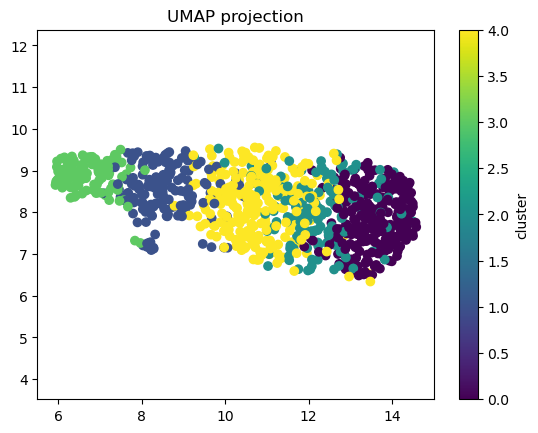

In [50]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=kmeans_labels)

plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(label = 'cluster')
plt.title('UMAP projection')

<!-- END QUESTION -->

_Cell Intentionally Blank_

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Download the zip file and submit to Gradescope.

In [51]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1b results: All test cases passed!

    q1c results: All test cases passed!

    q2b results: All test cases passed!

    q2c results: All test cases passed!
